# 🎨 NeMo Data Designer: Visual Question Answering Dataset Generation

> ⚠️ **Warning**: NeMo Data Designer is current in Early Release and is not recommended for production use.
>
> **Note**: In order to run this notebook, you must have the NeMo Data Designer microservice deployed locally via docker compose. See the [deployment guide](http://docs.nvidia.com/nemo/microservices/latest/set-up/deploy-as-microservices/data-designer/docker-compose.html) for more details.
>
> Alternatively, you can use the [NeMo Data Designer managed service](https://build.nvidia.com/nemo/data-designer). Please refer the [intro-tutorials](../../intro-tutorials/1-the-basics.ipynb) on how to connect to it. 
>
> **Note**: If you are using the NeMo Data Designer managed service, you will only be able to launch preview jobs. You will not be able to launch jobs using the `create` method.

This notebook demonstrates how to use NeMo Data Designer to generate high-quality synthetic Question-Answer datasets from visual documents. 

### Key Features Demonstrated

- ✨ **Visual Document Processing**: Converting images to chat-ready format
- 🏗️ **Structured Output Generation**: Using Pydantic models for consistent data schemas
- 🎯 **Multi-step Generation Pipeline**: Summary → Question → Answer generation workflow
- 🔄 **Iterative Development**: Preview functionality for rapid iteration



#### 💾 Install dependencies

**IMPORTANT** 👉 If you haven't already, follow the instructions in the [README](../../README.md) to install the necessary dependencies. Note you may need to restart your kernel after setting up the environment.


In [37]:
# Standard library imports
import io
import os
import json
import base64
import uuid

# Third-party imports
import pandas as pd
from datasets import load_dataset
from typing import Literal
from pydantic import BaseModel, Field
import rich
from rich.panel import Panel
from rich.markdown import Markdown

# NeMo Data Designer imports
from nemo_microservices import NeMoMicroservices
from nemo_microservices.beta.data_designer import (
    DataDesignerConfigBuilder,
    DataDesignerClient
)
from nemo_microservices.beta.data_designer.config import columns as C
from nemo_microservices.beta.data_designer.config import params as P

### ⚙️ Initialize the NeMo Data Designer Client

- The data designer client is responsible for submitting generation requests to the Data Designer microservice.
- In this notebook, we connect to a local deployment of data designer. You can deploy your own instance of data designer by following the deployment instructions [here](https://docs.nvidia.com/nemo/microservices/latest/set-up/deploy-as-microservices/data-designer/docker-compose.html).


In [38]:
data_designer_client = DataDesignerClient(client=NeMoMicroservices(base_url="http://localhost:8080"))

### 🏗️ Initialize the Data Designer Config Builder

- The Data Designer config defines the dataset schema and generation process.

- The config builder provides an intuitive interface for building this configuration.

- You must provide a list of model configs to the builder at initialization.

- This list contains the models you can choose from (via the `model_alias` argument) during the generation process.


In [39]:
# We specify the endpoint of the model during deployment using the model_provider_registry.
model_id = "mistralai/mistral-medium-3-instruct"
model_alias = "mistral-medium-3-instruct"

In [40]:
config_builder = DataDesignerConfigBuilder(
    model_configs=[
        P.ModelConfig(
            alias=model_alias,
            provider="nvidiabuild",
            model=model_id,
            inference_parameters=P.InferenceParameters(
                max_tokens=1024,
                temperature=0.6,
                top_p=0.95,
            ),
            is_reasoner=False
        ),
    ]
)

### 🌱 Seed Dataset Creation

In this section, we'll prepare our visual documents as a seed dataset. The seed dataset provides the foundation for synthetic data generation by:

- **Loading Visual Documents**: We use the ColPali dataset containing document images
- **Image Processing**: Convert images to base64 format for model consumption  
- **Metadata Extraction**: Preserve relevant document information
- **Sampling Strategy**: Configure how the seed data is utilized during generation

The seed dataset can be referenced in generation prompts using Jinja templating.

**Note**: At this time, we only support using a single file as the seed. If you have multiple files you would like to use as seeds, it is recommended you consolidated these into a single file. 

In [41]:
# Dataset processing configuration
IMG_COUNT = 512  # Number of images to process
CHAT_IMAGE_HEIGHT = 512  # Standardized height for model input

# Load ColPali dataset for visual documents
img_dataset_cfg = {
    "path": "vidore/colpali_train_set",
    "split": "train",
    "streaming": True
}

In [42]:
def resize_image(image, height: int):
    """
    Resize image while maintaining aspect ratio.

    Args:
        image: PIL Image object
        height: Target height in pixels

    Returns:
        Resized PIL Image object
    """
    original_width, original_height = image.size
    width = int(original_width * (height / original_height))
    return image.resize((width, height))

def convert_image_to_chat_format(record, height: int) -> dict:
    """
    Convert PIL image to base64 format for chat template usage.

    Args:
        record: Dataset record containing image and metadata
        height: Target height for image resizing

    Returns:
        Updated record with chat_image and uuid fields
    """
    # Resize image for consistent processing
    image = resize_image(record["image"], height)

    # Convert to base64 string
    img_buffer = io.BytesIO()
    image.save(img_buffer, format="PNG")
    byte_data = img_buffer.getvalue()
    base64_encoded_data = base64.b64encode(byte_data)
    base64_string = base64_encoded_data.decode("utf-8")

    # Return updated record
    return record | {
        "chat_image": f'<img src="data:image/png;base64,{base64_string}" />',
        "uuid": str(uuid.uuid4())
    }

In [43]:
# Load and process the visual document dataset
print("📥 Loading and processing document images...")

img_dataset_iter = iter(
    load_dataset(**img_dataset_cfg)
    .map(convert_image_to_chat_format, fn_kwargs={"height": CHAT_IMAGE_HEIGHT})
)
img_dataset = pd.DataFrame([next(img_dataset_iter) for _ in range(IMG_COUNT)])

print(f"✅ Loaded {len(img_dataset)} images with columns: {list(img_dataset.columns)}")

📥 Loading and processing document images...


Resolving data files:   0%|          | 0/82 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/82 [00:00<?, ?it/s]

✅ Loaded 512 images with columns: ['image', 'image_filename', 'query', 'answer', 'source', 'options', 'page', 'model', 'prompt', 'answer_type', 'chat_image', 'uuid']


In [44]:
img_dataset.head()

,image,image_filename,query,answer,source,options,page,model,prompt,answer_type,chat_image,uuid
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,images/1810.07757_2.jpg,"Comparing panels a, b, c, and d, which stateme...",D,arxiv_qa,['A. The variance of the data decreases from p...,,gpt4V,,None,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",c4f730b4-c09e-4b2a-8eb9-1b2367e54c65
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,data/scrapped_pdfs_split/pages_extracted/energ...,What is the duration of the course mentioned i...,"['five to ten hours, not including field trips']",pdf,None,9,sonnet,\n You are an assistant specialized in ...,None,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",fccd1259-0c0e-431e-bed8-3a035eed0efd
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,data/scrapped_pdfs_split/pages_extracted/energ...,What is the primary purpose of the PTC in lith...,['protect against external short circuits'],pdf,None,414,sonnet,\n You are an assistant specialized in ...,None,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",c2a4273b-2a8c-4cee-983f-990b3df6568c
3,<PIL.PngImagePlugin.PngImageFile image mode=L ...,0fd47b51ae9248ef36669b8619b1223f268edae3e7a44a...,What is the date?\nYour answer should be very ...,"OCTOBER 17, 1995.",docvqa,None,None,None,None,None,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",63ba344c-e482-4624-a172-f370b702b242
4,<PIL.PngImagePlugin.PngImageFile image mode=L ...,b335cfb9d442f8925ea41a064cb445a5395577f2345d52...,What is Bert Shulimson's title?\nYour response...,EXECUTIVE SECRETARY.,docvqa,None,None,None,None,None,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",2effc092-3715-4eec-b9d3-176f801929b4


In [45]:
os.makedirs("./data/", exist_ok=True)

df_seed = pd.DataFrame(img_dataset)[["uuid", "image_filename", "chat_image", "page", "options", "source"]]
df_seed.to_csv("./data/colpali_train_set.csv", index=False)


In [46]:
# Add the seed dataset containing our processed images
config_builder.with_seed_dataset(
    repo_id="advanced/visual-qna",
    filename="colpali_train_set.csv",
    dataset_path="./data/colpali_train_set.csv",
    sampling_strategy="ordered",
    with_replacement=True,
    datastore={"endpoint": "http://localhost:3000/v1/hf"},
)

colpali_train_set.csv:   0%|          | 0.00/71.0M [00:00<?, ?B/s]

DataDesignerConfigBuilder(
    seed_dataset: 'advanced/visual-qna/colpali_train_set.csv'
    seed_columns: [
        "uuid",
        "image_filename",
        "chat_image",
        "page",
        "options",
        "source"
    ]
)

In [47]:
# Add a column to generate detailed document summaries
config_builder.add_column(
    name="summary",
    type="llm-code",
    model_alias=model_alias,
    system_prompt=("You are a helpful assistant that summarizes images. "
                   "The image will be provided to you as a base64 encoded format."
                   "You must decode the image and then summarize the content of the image."),
    prompt=("{{ chat_image }}\n"
            "Provide a detailed summary of the content in this image in Markdown format."
            "Start from the top of the image and then describe it from top to bottom."
            "Place a summary at the bottom."),
    output_format="markdown"
)

DataDesignerConfigBuilder(
    seed_dataset: 'advanced/visual-qna/colpali_train_set.csv'
    seed_columns: [
        "uuid",
        "image_filename",
        "chat_image",
        "page",
        "options",
        "source"
    ]
    llm_code_columns: ['summary']
)

### 🎨 Designing our Data Schema

Structured outputs ensure consistent and predictable data generation. Data Designer supports schemas defined using:
- **JSON Schema**: For basic structure definition
- **Pydantic Models**: For advanced validation and type safety (recommended)

We'll use Pydantic models to define our Question-Answer schema:


In [ ]:
class Question(BaseModel):
    """Schema for generated questions"""
    question: str = Field(description="The question to be generated")

class QuestionTopic(BaseModel):
    """Schema for question topics"""
    topic: str = Field(description="The topic/category of the question")

class Options(BaseModel):
    """Schema for multiple choice options"""
    option_a: str = Field(description="The first answer choice")
    option_b: str = Field(description="The second answer choice")
    option_c: str = Field(description="The third answer choice")
    option_d: str = Field(description="The fourth answer choice")

class Answer(BaseModel):
    """Schema for question answers"""
    answer: Literal["option_a", "option_b", "option_c", "option_d"] = Field(description="The correct answer to the question")


In [49]:
config_builder.add_column(
    C.SamplerColumn(
        name="difficulty",
        type=P.SamplerType.CATEGORY,
        params=P.CategorySamplerParams(values=["easy", "medium", "hard"]),
        description="The difficulty of the generated question",
    ))

# Optionally validate that the columns are configured correctly.
config_builder.validate()


[08:54:36] [INFO] ✅ Validation passed


DataDesignerConfigBuilder(
    seed_dataset: 'advanced/visual-qna/colpali_train_set.csv'
    seed_columns: [
        "uuid",
        "image_filename",
        "chat_image",
        "page",
        "options",
        "source"
    ]
    sampler_columns: ['difficulty']
    llm_code_columns: ['summary']
)

In [50]:
config_builder.add_column(
    C.LLMStructuredColumn(
        name="question",
        model_alias=model_alias,
        prompt=("Generate a question based on the following context: {{ summary }}. "
        "The difficulty of the generated question should be {{ difficulty }}"),
        system_prompt=("You are a helpful assistant that generates questions based on the given context. "
        "The context are sourced from documents pertaining to the petroleum industry. "
        "You will be given a context and you will need to generate a question based on the context. "
        "The difficulty of the generated question should be {{ difficulty }}"
        "Ensure you generate just the question and no other text."),
        output_format=Question,
    )
)

config_builder.add_column(
    C.LLMStructuredColumn(
        name="options",
        model_alias=model_alias,
        prompt=("Generate four answer choices for the question: {{ question }} based on the following context: {{ summary }}. "
        "The option you generate should match the difficulty of the generated question, {{ difficulty }}."),
        output_format=Options,
    )
)


config_builder.add_column(
    C.LLMStructuredColumn(
        name="answer",
        prompt=("Choose the correct answer for the question: {{ question }} based on the following context: {{ summary }}"
                "and options choices. The options are {{ options }}. Only select one of the options as the answer."),
        output_format=Answer,
        model_alias=model_alias,
    )
)


config_builder.add_column(
    C.LLMStructuredColumn(
        name="topic",
        model_alias=model_alias,
        prompt=("Generate the topic of the question: {{ question }} based on the following context: {{ summary }}"
        "The topic should be a single word or phrase that is relevant to the question and context. "),
        system_prompt=("Generate a short 1-3 word topic for the question: {{ question }} based on the given context. {{ summary }}"),
        output_format=QuestionTopic,
    )
)

config_builder.validate()

[08:54:36] [INFO] ✅ Validation passed


DataDesignerConfigBuilder(
    seed_dataset: 'advanced/visual-qna/colpali_train_set.csv'
    seed_columns: [
        "uuid",
        "image_filename",
        "chat_image",
        "page",
        "source"
    ]
    sampler_columns: ['difficulty']
    llm_code_columns: ['summary']
    llm_structured_columns: [
        "options",
        "question",
        "answer",
        "topic"
    ]
)

### 👀 Preview Generation

Before scaling up, it's crucial to validate your configuration with a small sample. The preview functionality:

- **Generates Sample Data**: Creates 10 records for quick inspection
- **Enables Rapid Iteration**: Test and refine your prompts and schemas
- **Provides Detailed Logging**: Understand the generation process with verbose output

Use this step to fine-tune your configuration before full-scale generation.


In [51]:
preview = data_designer_client.preview(config_builder, verbose_logging=True)

[08:54:37] [INFO] 🌱 Step 1: Seeding workflow with dataset
[08:54:47] [INFO]   |-- ✂️ Truncating input dataset down to 10 records from 512
[08:55:12] [INFO] 🎲 Step 2: Using samplers to generate 1 columns
[08:55:13] [INFO]   |-- 🎲 Using numerical samplers to generate 10 records across 1 columns
[08:55:13] [INFO] 🔗 Step 3: Concatenating seed and sampler datasets
[08:55:14] [INFO]   |-- (💾 + 💾) Concatenating 2 datasets
[08:55:14] [INFO] 🦜 Step 4: Generating code column `summary`
[08:55:14] [INFO]   |-- 📝 Preparing template to generate data column `summary`
[08:55:14] [INFO]   |   |-- model_alias: mistral-medium-3-instruct
[08:55:14] [INFO]   |-- 🩺 Running health check for model with alias 'mistral-medium-3-instruct'
[08:55:14] [INFO]   |-- ✅ Health check completed for model with alias 'mistral-medium-3-instruct'
[08:55:25] [INFO]   |-- Model config being used for model alias 'mistral-medium-3-instruct': 
{
    "alias": "mistral-medium-3-instruct",
    "model": {
        "api_endpoint": {
 

In [52]:
# Display a sample record from the preview
# Run this cell multiple times to cycle through different records
preview.display_sample_record()

                                                   Seed Columns                                                    
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Name           ┃ Value                                                                                          ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ uuid           │ 656f62a2-7f70-4cf6-b54e-2b755a1bde04                                                           │
├────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────┤
│ image_filename │ data/scrapped_pdfs_split/pages_extracted/energy_train/3794f052-3c8b-4890-afd2-49500c29ae26.pd… │
├────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────┤
│ chat_image     │ <img                                                                                           │
│                │ src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYsAAAIACAIAAAD8HddaAAEAAElEQVR4nOy9Z3RTV9… │
│                │ />                                                                                             │
├────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────┤
│ page           │ 592.0                                                                                          │
├────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────┤
│ source         │ pdf                                                                                            │
└────────────────┴────────────────────────────────────────────────────────────────────────────────────────────────┘
                                                                                                                   
                                                                                                                   
                                                 Generated Columns                                                 
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Name       ┃ Value                                                                                              ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ difficulty │ easy                                                                                               │
├────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ options    │ {                                                                                                  │
│            │     'option_a': 'To outline the methodology for establishing baseline emission performance for     │
│            │ affected EGUs',                                                                                    │
│            │     'option_b': 'To provide a history of the Environmental Protection Agency',                     │
│            │     'option_c': 'To discuss the benefits of using natural gas in power plants',                    │
│            │     'option_d': 'To explain the process of building new emission generating units'                 │
│            │ }                                                                                                  │
├────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ question   │ {'question': 'What is the purpose of the document discussed in the context?'}                      │
├────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ answer     │ {'answer': 'option_a'}                   

In [53]:
# The preview dataset is available as a pandas DataFrame.
preview.dataset

,uuid,image_filename,chat_image,page,options,source,difficulty,summary,question,topic,answer
0,656f62a2-7f70-4cf6-b54e-2b755a1bde04,data/scrapped_pdfs_split/pages_extracted/energ...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",592.0,"{""option_a"": ""To outline the methodology for e...",pdf,easy,# Summary of the Image Content\n\n## Text Cont...,"{""question"": ""What is the purpose of the docum...","{""topic"": ""Document purpose""}","{""answer"": ""option_a""}"
1,2effc092-3715-4eec-b9d3-176f801929b4,b335cfb9d442f8925ea41a064cb445a5395577f2345d52...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",NaN,"{""option_a"": ""THE WELFARE OF THE PEOPLE SHALL ...",docvqa,easy,# Document Summary\n\n## Header\n- **Logo and ...,"{""question"": ""What is the motto of the Missour...","{""topic"": ""MASW motto""}","{""answer"": ""option_a""}"
2,63ba344c-e482-4624-a172-f370b702b242,0fd47b51ae9248ef36669b8619b1223f268edae3e7a44a...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",NaN,"{""option_a"": ""Continuous Combined and Cyclic H...",docvqa,easy,# Image Summary\n\n## Top Section\n- **Handwri...,"{""question"": ""What is the title of the medical...","{""topic"": ""Study Title""}","{""answer"": ""option_a""}"
3,fccd1259-0c0e-431e-bed8-3a035eed0efd,data/scrapped_pdfs_split/pages_extracted/energ...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",9.0,"{""option_a"": ""The course integrates theoretica...",pdf,hard,# Summary of the Image Content\n\n## Header\n-...,"{""question"": ""How does the course on energy co...","{""topic"": ""Energy conservation training""}","{""answer"": ""option_c""}"
4,c3ffefb1-ba0d-4156-8cbb-f313a10f61d4,data/scrapped_pdfs_split/pages_extracted/gover...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",37.0,"{""option_a"": ""Prepare aging schedules and enfo...",pdf,medium,# Liberty Medical Group: Detailed Ratio Analys...,"{""question"": ""What are some strategies Liberty...","{""topic"": ""Accounts Receivable Strategies""}","{""answer"": ""option_d""}"
5,c4f730b4-c09e-4b2a-8eb9-1b2367e54c65,images/1810.07757_2.jpg,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",NaN,"{""option_a"": ""The increase in structure and sm...",arxiv_qa,hard,# Image Summary\n\n## Color Bar\n- At the top ...,"{""question"": ""Analyze the progression of patte...","{""topic"": ""Heatmap pattern analysis""}","{""answer"": ""option_a""}"
6,c2a4273b-2a8c-4cee-983f-990b3df6568c,data/scrapped_pdfs_split/pages_extracted/energ...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",414.0,"{""option_a"": ""Temperature significantly impact...",pdf,hard,# Lithium Batteries - Summary\n\n## Content\n\...,"{""question"": ""Analyze the impact of temperatur...","{""topic"": ""Li/FeS₂ battery performance""}","{""answer"": ""option_a""}"
7,50ea0319-5af6-47dd-af59-9fe1335c00c2,data/scrapped_pdfs_split/pages_extracted/healt...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",278.0,"{""option_a"": ""An ACO must have a formal legal ...",pdf,medium,# Summary of Image Content\n\n## Header\n- **T...,"{""question"": ""According to Public Law 111-148,...","{""topic"": ""ACO Requirements""}","{""answer"": ""option_b""}"
8,aceac519-3906-4d25-b602-ab2c03ad43ff,images/2304.05488_0.jpg,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",NaN,"{""option_a"": ""The transformation pattern shows...",arxiv_qa,hard,# Image Summary: Graph Transformations\n\n## T...,"{""question"": ""Analyze the transformation patte...","{""topic"": ""Graph edge transformations""}","{""answer"": ""option_a""}"
9,29cda15b-b5fe-4ef9-a608-7ae17746b3e3,data/scrapped_pdfs_split/pages_extracted/artif...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",582.0,"{""option_a"": ""CT kerma indexes are significant...",pdf,hard,# Patient Dosimetry\n\n## Radiation Neglect\nR...,"{""question"": ""Explain the significance of the ...","{""topic"": ""CT dosimetry""}","{""answer"": ""option_a""}"


📄 Original Document Image:


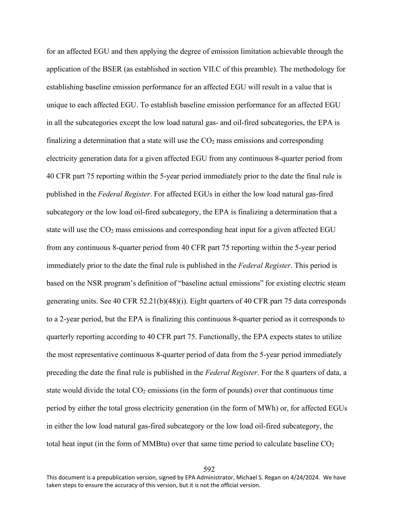


📝 Generated Summary:


╭─ Document Summary ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ # Summary of the Image Content                                                                                  │
│                                                                                                                 │
│ ## Text Content                                                                                                 │
│                                                                                                                 │
│ The document discusses methodologies for establishing baseline emission performance for affected Emission       │
│ Generating Units (EGUs) as part of a regulatory framework. Here is a detailed breakdown:                        │
│                                                                                                                 │
│ 1. **Purpose and Scope**:                                                                                       │
│    - The text aims to outline the methodology for establishing baseline emission performance for affected EGUs. │
│    - The methodology is unique for each affected EGU and applies to all subcategories except low load natural   │
│ gas- and oil-fired subcategories.                                                                               │
│                                                                                                                 │
│ 2. **Data Collection**:                                                                                         │
│    - The Environmental Protection Agency (EPA) will use CO2 mass emissions and corresponding heat input data    │
│ from a continuous 8-quarter period.                                                                             │
│    - The data corresponds to the final rule published in the Federal Register.                                  │
│                                                                                                                 │
│ 3. **Methodology**:                                                                                             │
│    - For affected EGUs in the low load natural gas-fired subcategory, the EPA will use CO2 mass emissions and   │
│ heat input from the most representative continuous 8-quarter period.                                            │
│    - The methodology involves dividing the total CO2 emissions by the total heat input or total gross           │
│ electricity generation to calculate baseline CO2 emission rates.                                                │
│                                                                                                                 │
│ 4. **Regulatory Context**:                                                                                      │
│    - The document is a prepublication version signed by Michael S. Regan, EPA Administrator, on April 24, 2024. │
│    - It is part of the regulatory framework established under section VILC of the preamble.                     │
│                                                                                                                 │
│ 5. **Technical Details**:                                                                                       │
│    - The EPA will use the NSR program’s definition of “baseline actual emissions” for existing steam generating │
│ units.                                                                                                          │
│    - The document specifies the use of data from 40 CFR part 75 reporting within the 5-year period immediately  │
│ prior to the date the final rule is published.                                                                  │
│                                                                                                                 │
│ ## Summary                                            


❓ Generated Question:


╭─ Question ──────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ {"question": "What is the purpose of the document discussed in the context?"}                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


🔢 Generated Options:


╭─ Answer Choices ────────────────────────────────────────────────────────────────────────────────────────────────╮
│ {"option_a": "To outline the methodology for establishing baseline emission performance for affected EGUs",     │
│ "option_b": "To provide a history of the Environmental Protection Agency", "option_c": "To discuss the benefits │
│ of using natural gas in power plants", "option_d": "To explain the process of building new emission generating  │
│ units"}                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


✅ Generated Answer:


╭─ Correct Answer ────────────────────────────────────────────────────────────────────────────────────────────────╮
│ {"answer": "option_a"}                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [54]:
# Compare original document with generated outputs
index = 0  # Change this to view different examples

# Merge preview data with original images for comparison
comparison_dataset = preview.dataset.merge(
    pd.DataFrame(img_dataset)[["uuid", "image"]],
    how="left",
    on="uuid"
)

print("📄 Original Document Image:")
display(resize_image(comparison_dataset.image[index], CHAT_IMAGE_HEIGHT))

print("\n📝 Generated Summary:")
rich.print(Panel(comparison_dataset.summary[index], title="Document Summary", title_align="left"))

print("\n❓ Generated Question:")
rich.print(Panel(comparison_dataset.question[index], title="Question", title_align="left"))

print("\n🔢 Generated Options:")
rich.print(Panel(comparison_dataset.options[index], title="Answer Choices", title_align="left"))

print("\n✅ Generated Answer:")
rich.print(Panel(comparison_dataset.answer[index], title="Correct Answer", title_align="left"))


### 🚀 Scale Up Generations

Once satisfied with the preview results, scale up to generate the full dataset. The generation process offers flexible execution modes:

#### Synchronous Generation
Set `wait_until_done=True` to block until completion - ideal for smaller datasets or interactive workflows.

#### Asynchronous Generation  
Set `wait_until_done=False` for batch processing - returns a `job_id` for later retrieval:

In [ ]:
job_results = data_designer_client.create(config_builder, num_records=1, wait_until_done=False)

job_results.wait_until_done()

In [ ]:
# load the dataset into a pandas DataFrame
dataset = job_results.load_dataset()

print(f"Generated {len(dataset)} records")

dataset.head()

### 🔎 View Results

In [ ]:
# Compare original document with generated outputs
index = 0  # Change this to view different examples

# Merge preview data with original images for comparison
comparison_dataset = dataset.merge(
    pd.DataFrame(img_dataset)[["uuid", "image"]],
    how="left",
    on="uuid"
)

print("📄 Original Document Image:")
display(resize_image(comparison_dataset.image[index], CHAT_IMAGE_HEIGHT))

print("\n📝 Generated Summary:")
rich.print(Panel(comparison_dataset.summary[index], title="Document Summary", title_align="left"))

print("\n❓ Generated Question:")
rich.print(Panel(comparison_dataset.question[index], title="Question", title_align="left"))

# print("\n🔢 Generated Options:")
# rich.print(Panel(comparison_dataset.options[index], title="Answer Choices", title_align="left"))

print("\n✅ Generated Answer:")
rich.print(Panel(comparison_dataset.answer[index], title="Correct Answer", title_align="left"))
